In [53]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.log_normal import LogNormal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence

import seaborn as sns
import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.censored_normal import CensoredNormal
from delphi.distributions.truncated_normal import TruncatedNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import Parameters
from cox.store import Store
from cox.readers import CollectionReader

In [92]:
args = Parameters({ 
    'samples': 1000, 
    'batch_size': 1, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp/log_normal/',
    'exp': 'second_exp', 
    'trials': 20,
    'var': 10,
    'table_name': 'logs',
})

Synthetic Data Experiment for 1 Dimensional Censored Gaussian Distributions 

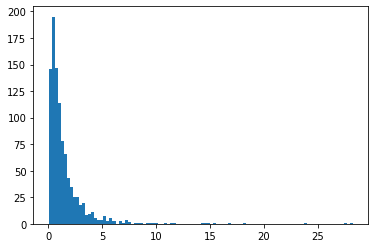

In [39]:
M = LogNormal(Tensor([0.0]), 1.0*ch.ones(1,))
samples = M.sample([args.samples])

plt.hist(samples.flatten(), bins=100)
plt.show()

In [49]:
M_ = MultivariateNormal(Tensor([0.0]), 1.0*ch.ones(1, 1))

Truncate the Dataset

alpha: 0.533


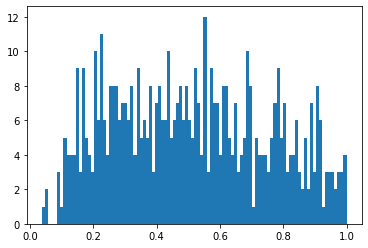

In [40]:
phi = oracle.Right_Distribution(Tensor([1.0]))
# phi = oracle.Identity()
indices = phi(samples).nonzero()[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))

plt.hist(S.flatten(), bins=100)
plt.show()

In [91]:
S_ = ch.log(S)
emp_loc = S_.mean(0).flatten()
print("empirical mean: ", emp_loc)
emp_var = S_.var(0)[...,None]
emp_scale = ch.sqrt(emp_var)
print("empirical scale: ", emp_scale)

emp = MultivariateNormal(emp_loc, emp_var)

S_norm = (S_ - emp_loc) / emp_scale
phi_norm = oracle.Right_Distribution(((ch.log(phi.right) - emp_loc) / emp_scale).flatten())

empirical mean:  tensor([nan])
empirical scale:  tensor([[nan]])


ValueError: Expected parameter loc (Tensor of shape (1,)) of distribution MultivariateNormal(loc: tensor([nan]), covariance_matrix: tensor([[nan]])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan])

Run algorithm to Remove Bias from the Dataset

In [51]:
train_kwargs = Parameters({'phi': phi_norm, 
                           'alpha': alpha,
                          'epochs': 5, 
                          'batch_size': 10, 
                          'num_samples': 10,
                          'step_lr': 500,
                          'lr': 1e-1})
censored = CensoredNormal(train_kwargs)
censored.fit(S_norm)
rescale_loc = censored.loc * emp_scale + emp_loc
rescale_var = censored.variance * emp_var
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated variance: ", rescale_var)

estimated mean:  tensor([[-0.2582]])
estimated variance:  tensor([[0.7596]])


In [52]:
print("censored kl divergence: ", kl_divergence(m, M_))
print("empirical kl divergence: ", kl_divergence(emp, M_))

censored kl divergence:  tensor([0.0506])
empirical kl divergence:  tensor(0.5426)


In [60]:
train_kwargs = Parameters({'alpha': alpha,
                          'epochs': 10, 
                          'batch_size': 10, 
                          'step_lr': 500,
                          'lr': 1e-1})
truncated = TruncatedNormal(train_kwargs)
truncated.fit(S_)
rescale_loc = truncated.loc
rescale_var = truncated.variance
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated variance: ", rescale_var)

estimated mean:  tensor([-0.4364])
estimated variance:  tensor([[0.8026]])


In [61]:
print("truncated kl divergence: ", kl_divergence(m, M_))
print("empirical kl divergence: ", kl_divergence(emp, M_))

truncated kl divergence:  tensor(0.1064)
empirical kl divergence:  tensor(0.5426)


In [97]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'var': int,
    'alpha': float,
}

store.add_table(args.table_name, schema)

for i in range(args.trials): 
    gt_loc = Uniform(-1, 1).sample([1,])
    for var in range(1, args.var + 1):
        # create new dataset
        gt_var = var * ch.ones(1,)
        gt_dist = LogNormal(gt_loc, ch.sqrt(gt_var))
        samples = gt_dist.sample([args.samples])
        samples_ = ch.log(samples)
        M = MultivariateNormal(samples_.mean(0), samples_.var(0)[...,None])

        # right truncate at 0
        phi = oracle.Right_Distribution(Tensor([1.0]))
        indices = phi(samples).nonzero()[:,0]
        # exponentiate samples
        S = samples[indices]
        S_ = ch.log(S)
        alpha = S.size(0) / samples.size(0)

        emp_dist = MultivariateNormal(S_.mean(0), S_.var(0)[...,None])

        S_norm = (S - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix)
        phi_norm = oracle.Right_Distribution(((phi.right - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix)).flatten())

        train_kwargs = Parameters({'phi': phi_norm, 
                                   'alpha': alpha,
                                    'epochs': 10, 
                                    'batch_size': 100, 
                                    'num_samples': 10,
                                    'lr': 1e-1})

        censored = CensoredNormal(train_kwargs)
        censored.fit(S_norm)


        loc_ = (censored.loc * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
        var_ = censored.variance * emp_dist.covariance_matrix

        censor_dist = MultivariateNormal(loc_, var_)

        kl_censor = float(kl_divergence(M, censor_dist))
        kl_emp = float(kl_divergence(M, emp_dist))


        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_censored': kl_censor,
            'var': var,
            'alpha': alpha,
        })
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()

    
store.close()

In [98]:
reader = CollectionReader(args.out_dir + args.exp)
logs = reader.df(args.table_name)
reader.close()
logs.head(10)

100%|██████████| 5/5 [00:00<00:00, 371.53it/s]

,kl_div_emp,kl_div_censored,var,alpha,exp_id
0,1.600170,7.319287,1,0.453,fff28041-b454-4a21-9193-7004f4c9c218
1,1.363928,13.086485,2,0.461,fff28041-b454-4a21-9193-7004f4c9c218
2,1.363856,18.314875,3,0.466,fff28041-b454-4a21-9193-7004f4c9c218
3,1.685957,27.465103,4,0.451,fff28041-b454-4a21-9193-7004f4c9c218
4,1.590561,28.850222,5,0.459,fff28041-b454-4a21-9193-7004f4c9c218
5,1.303516,38.340576,6,0.465,fff28041-b454-4a21-9193-7004f4c9c218
6,1.237974,40.213161,7,0.479,fff28041-b454-4a21-9193-7004f4c9c218
7,1.175969,52.188328,8,0.494,fff28041-b454-4a21-9193-7004f4c9c218
8,1.478107,64.250610,9,0.473,fff28041-b454-4a21-9193-7004f4c9c218
9,1.392226,75.695442,10,0.474,fff28041-b454-4a21-9193-7004f4c9c218


In [99]:
print("kl emp div: {}".format(logs.kl_div_emp.mean()))
print("kl censor div: {}".format(logs.kl_div_censored.mean()))

kl emp div: 1.554237509071827
kl censor div: 38.92602833747864


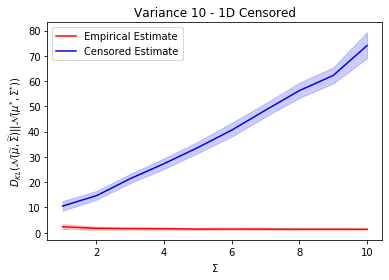

In [100]:
sns.lineplot(data=logs, x='var', y='kl_div_emp', color='red', label='Empirical Estimate')
ax = sns.lineplot(data=logs, x='var', y='kl_div_censored', color='blue', label='Censored Estimate')
ax.set_title('Censored Normal Varying Distribution Variance')
ax.set_xlabel('$\Sigma$')
ax.set_ylabel('$D_{KL}(\mathcal{N}(\widetilde{\mu}, \widetilde{\Sigma}) || \mathcal{N}(\mu^{*}, \Sigma^{*}))$')
ax.set_title('Variance 10 - 1D Censored')
ax.legend()
plt.show()

In [54]:
gt_dist = MultivariateNormal(ch.zeros(1) + .5, ch.ones(1, 1))

In [90]:
ch.log(samples[indices].mean(0)), S.mean(0)

(tensor([-1.5845]), tensor([-2.7102]))

In [88]:
ch.log(samples[indices]).mean(0)

tensor([-2.7102])

In [13]:
test = ch.randn(5,)

In [14]:
ch.nn.Parameter(test)

Parameter containing:
tensor([-0.6663, -2.3218,  0.3456,  1.4994,  1.4930], requires_grad=True)